# Build our LLM From Scratch -

## How Cerebros NotGPT works under the hood:


### This notebook demonstrates the end-to-end training pipeline that builds a small scale generative LLM from scratch, a small scale proof of concept for our own Cerebros NotGPT model, then fine tunes it on additional data.

The process is divided into two main phases:

- Phase I-a: Neural Architecture Search (NAS) - We use SimpleCerebrosRandomSearch to automatically discover an effective neural network architecture from a small dataset.
- Phase I-b: Extended Training - The best architecture found in Phase I-a is then trained on a larger dataset to improve its performance.

Finally, the trained model is evaluated and serialized for future use.


## Setup and Configuration

Note: This script is configured as a vanilla-scale demo environment (4 CPU / 16 GB RAM Linux with Python 3.12). No GPU is needed, and this will run in the free version of Google Colab.  

## Vanilla Demo

- For production use, you would significantly increase the sample sizes and adjust other parameters accordingly.
- The quality of the text generated by this minimal demo (trained on 30 text samples at a sequence length of 40) does not represent the quality of a full-scale model generated from the same code.
- A script that can be modified to do such as availible at: https://github.com/david-thrower/cerebros-core-algorithm-alpha/blob/main/train_a_generative_llm.py

In [24]:
! python --version

Python 3.12.12


# Getting started: Download the repo and go to the main directory of the repo

In [25]:
# Download the repo
! git clone https://github.com/david-thrower/cerebros-core-algorithm-alpha.git

Cloning into 'cerebros-core-algorithm-alpha'...
remote: Enumerating objects: 8036, done.
remote: Counting objects: 100% (1737/1737), done.
remote: Compressing objects: 100% (321/321), done.
remote: Total 8036 (delta 1612), reused 1449 (delta 1411), pack-reused 6299 (from 2)
Receiving objects: 100% (8036/8036), 65.90 MiB | 21.67 MiB/s, done.
Resolving deltas: 100% (3116/3116), done.


In [26]:
# set the working directory
%cd cerebros-core-algorithm-alpha

/content/cerebros-core-algorithm-alpha/cerebros-core-algorithm-alpha


# Next install all dependencies.

There are 2 requirement files:
 - requirements.txt: The core requirements of the neural architecture search
 - cicd-requirements.txt: Requirements for NLP and text generation

In [27]:
# Install the requirements for the core algorithm
! pip install -r requirements.txt; pip install -r cicd-requirements.txt

  Using cached tensorflow-2.20.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
Using cached tensorflow-2.20.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (620.7 MB)
Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
Using cached tensorboard-2.20.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.1
    Uninstalling tensorflow-2.19.1:
      Successfu

# **RESTART THE SESSION**

Then proceed to the next cell which imports all necessary libraries and defines global constants and hyperparameters for the entire pipeline.


In [1]:
! ls

cerebros-core-algorithm-alpha  sample_data


In [2]:
# 1. # **ONLY IF** the directory cerebros-core-algorithm-alpha is not still
# there, clone the directory again.
# ! git clone https://github.com/david-thrower/cerebros-core-algorithm-alpha.git

# 2. Set the working directory (in the new session) - DO run this.
%cd cerebros-core-algorithm-alpha

/content/cerebros-core-algorithm-alpha


In [3]:
# Verify we are in the right place:
! pwd

/content/cerebros-core-algorithm-alpha


In [4]:
# Standard library imports
import subprocess
import time
from gc import collect

# Third-party library imports
import tensorflow as tf
import pandas as pd
import pendulum
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

# Cerebros specific imports
from cerebros.units.units import DenseUnit
from cerebros.simplecerebrosrandomsearch.simple_cerebros_random_search import SimpleCerebrosRandomSearch
from cerebros.denseautomlstructuralcomponent.dense_automl_structural_component import (
    zero_7_exp_decay,
    zero_95_exp_decay,
    simple_sigmoid
)
from cerebrosllmutils.llm_utils import (
    prepare_data,
    InterleavedRoPE,
    Perplexity,
    CerebrosNotGPTConfig,
    CerebrosNotGPT,
    WarmupCosineDecayRestarts
)

# Import the data source: Format List[str]
from vanilladatasets.web_english_bible import samples as bible



/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(


# Data and Training Constants

These parameters control the amount of data used and the behavior of the training stages.

- **PHASE_I_A_SAMPLES_TO_CREATE**: Size of the subset of the dataset used for the NAS (Neural Architecture Search) stage (number of text samples).
- **PHASE_I_B_SAMPLES_TO_CREATE**: Number of samples to use for the main training task stage after Neural Architecture Search is completed.
- **PHASE_I_B_VAL_SPLIT**: Fraction of data for validation in Phase I-b.
- **PHASE_I_B_SAMPLE_EXPANSION_BATCH_SIZE**: Batch size for preprocessing in Phase I-b to manage RAM.
- **PROMPT_LENGTH**: Number of tokens provided to the model to predict the next token. It is recommended to keep this as 1.


In [5]:
# Samples to use for the neural architecture search stage
PHASE_I_A_SAMPLES_TO_CREATE = 10

# Samples to use for the main training stage
PHASE_I_B_SAMPLES_TO_CREATE = 20
PHASE_I_B_VAL_SPLIT = 0.15

# For Stage I-b, we preprocess in batches to avoid high RAM usage.
PHASE_I_B_SAMPLE_EXPANSION_BATCH_SIZE = 10

# How many tokens to provide before expecting the next token to be predicted.
PROMPT_LENGTH = 1


# Model and Embedding Constants

These constants define the size and shape of the model's text processing components.

- **MAX_SEQ_LENGTH**: The maximum sequence length the model will handle. This has a linear relationship with RAM/CPU usage.
- **tokenizer_checkpoint**: The Hugging Face model to use for tokenization.
- **EMBEDDING_N**: A factor to determine the embedding dimensionality (EMBEDDING_DIM = EMBEDDING_N * 2). A factor to determine the embedding dimensionality (EMBEDDING_DIM = EMBEDDING_N * 2). The resulting embedding dimensionality (EMBEDDING_DIM) for InterleavedRoPE must be an even number. Using this parameter as a proxy, rather than setting EMBEDDING_DIM directly, acts as a guard rail to ensure this constraint is met.
- **PROJECTION_N**: Controls the size of a projection layer after embedding. Increasing this value can significantly increase RAM usage.


In [6]:
# Text encoding / embedding related constants
MAX_SEQ_LENGTH = 40

# Tokenization
tokenizer_checkpoint = "HuggingFaceTB/SmolLM3-3B"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)

# Add special tokens for potential instruction-following formats
special_tokens = {
    "additional_special_tokens": ["<prompt>", "</prompt>", "<response>", "</response>"]
}
tokenizer.add_special_tokens(special_tokens)

VOCABULARY_SIZE = len(tokenizer)

# For InterleavedRoPE, the embedding output dim must be an even number.
EMBEDDING_N = 6
EMBEDDING_DIM = int(EMBEDDING_N * 2)

# Size of the projection layer. Keep low to manage RAM.
PROJECTION_N = 1


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Stage I-a (NAS) Hyperparameters

These parameters control the Neural Architecture Search process.

- **moities_to_try**: Number of different layer permutations to try.
- **tries_per_moity**: Number of topologies to try for each permutation.
- **epochs, batch_size, learning_rate**: Standard training parameters for the NAS stage.
- **predecessor_level_connection_affinity_factor_first**: Controls connectivity density between the Input layer and the first level of Dense layers.
- **predecessor_level_connection_affinity_factor_main**: Controls connectivity density between the Input layer and the first level of Dense layers and the subsequent level of Dense layers, as well as all subsequent vertical connectivity.
- **p_lateral_connection, num_lateral_connection_tries_per_unit**: Control the density of lateral connectivity between Dense layers on the same row.
- **minimum_levels, maximum_levels**: Number of **rows of** Dense layers in the architecture grid.
- **minimum_units_per_level, maximum_units_per_level**: Number of Dense layers per row.
- **minimum_neurons_per_unit, maximum_neurons_per_unit**: The number of neurons for each Dense layer unit.


In [7]:
# Cerebros [non-HP-tunable] configurables for NAS
moities_to_try = 3
tries_per_moity = 1

###  Main tunable hyperparameters for NAS ##

POSITIONAL_EMBEDDING_DROPOUT = 0.7651951380000674
activation = 'softplus'

# Vertical connectivity hyperparameters
predecessor_level_connection_affinity_factor_first = 17.851026458010523
predecessor_level_connection_affinity_factor_main = 21.487301631581428

# Lateral connectivity hyperparameters
max_consecutive_lateral_connections = 7
p_lateral_connection = 0.24927354102044022
num_lateral_connection_tries_per_unit = 32
learning_rate = 0.003025583248301791
epochs = 41
batch_size = 5
gradient_accumulation_steps = 4

# Architecture grid constraints
minimum_levels = 2
maximum_levels = 2
minimum_units_per_level = 2
maximum_units_per_level = 2
minimum_neurons_per_unit = 2
maximum_neurons_per_unit = 2


# Phase I-b (Extended Training) Hyperparameters

These parameters are for fine-tuning the best model from Stage I-a.

- INITIAL_LR_STAGE_I_B: Initial learning rate for this phase.
- WARMUP_EPOCHS_STAGE_I_B, WARMUP_STEPS: Parameters for the learning rate scheduler.
- phase_i_b_epochs: Number of epochs for extended training.
- phase_i_b_weight_decay: Weight decay for the optimizer.


In [8]:

## Training Stage I-b parameters:
INITIAL_LR_STAGE_I_B = 0.0039295722955565125
WARMUP_EPOCHS_STAGE_I_B = 7
WARMUP_STEPS = 1140
FIRST_DECAY_STEPS_STAGE_I_B = 1900
phase_i_b_epochs = 53
phase_i_b_gradient_accumulation_steps = 7
phase_i_b_weight_decay = 0.01647018768215773 # For AdamW



# Generation Constants

Parameters used during the text generation evaluation phase.

In [9]:
## Generation time configurables:
GENERATION_PROMPT_LEN = 25
MAX_NEW_TOKENS = MAX_SEQ_LENGTH - GENERATION_PROMPT_LEN

# **Data Preparation**

Here, we load and subset the dataset for both training Stages.


We first split the Bible text samples into two sets: one for Phase I-a (NAS) and a larger one for Phase I-b (extended training).


In [10]:
# Get training data from the bible text samples
non_instruct_samples = bible[:PHASE_I_A_SAMPLES_TO_CREATE]
phase_i_b_samples = bible[PHASE_I_A_SAMPLES_TO_CREATE:PHASE_I_B_SAMPLES_TO_CREATE + PHASE_I_A_SAMPLES_TO_CREATE]

print(f"Samples from KJV bible consisting of {len(non_instruct_samples)} look like this (sub-sample of 3): {non_instruct_samples[:3]}")


Samples from KJV bible consisting of 10 look like this (sub-sample of 3): ['In the beginning God created the heavens and the earth.', "The earth was formless and empty, with darkness over the deep and God's Spirit hovering over the waters.", "God said, 'Let there be light,' and there was light."]


# Preprocess Data for Phase I-a (NAS)

The Cerebros LLM is a single head model. This means that each time the model is called, it returns only the next token. It does not regurgitate the cumulative sequence, nor does it have a separate head for each position in the sequence.

For both training stages, each text sample is expanded into multiple input/label pairs, which we call "sub-samples." There is one "sub-sample" for each token in the range between the first token and the first occurrence of a padding token or the end of the sequence, whichever comes first.

For example, the sequence [t1, t2, t3] becomes:

    Input: [t1, 2,  2,  2]  Label: [t2] # One hot encoded to VOCABULARY_SIZE
    Input: [t1, t2, 2,  2], Label: [t3]
    Input: [t1, t2, t3, 2], Label: [2]

For training Stage 1-a, we perform the entire expansion for its training data in memory. This is because the NAS does not yet support a tf.data.Dataset object. In the future, we may retrofit the NAS algorithm to support streaming preprocessing as well, allowing us to use a larger dataset for the NAS.

For stage I-b, the extended training stage, the same operation is done in batches. This is because this operation significantly increases the amount of memory required. The main reason for this is the one-hot encoded label, where the vocabulary size is 128,260. Since we do this in batches, this allows for a virtually unlimited number of samples to be processed.

For reference, this is the preprocessing being applied:

```python
def prepare_data(
        data_0: List[str],
        tokenizer_0: Any,
        max_seq_length: int = 1024,
        prompt_length: int = 1) -> Tuple[List[List[int]], List[List[int]], int]:


    all_input_ids = []
    all_labels = []

    pad_token_id = tokenizer_0.pad_token_id

    # Tokenize all data at once for efficiency
    tokenized_data = tokenizer_0(
        data_0,
        max_length=max_seq_length,
        padding='max_length',
        truncation=True,
        add_special_tokens=False  # We'll handle special tokens manually
    )
    vocab_size = len(tokenizer_0)

    # Get the token ID for </prompt>
    end_prompt_token_id = tokenizer_0.encode("</prompt>", add_special_tokens=False)[0]

    # Process each sample
    for sample_tokens in tokenized_data['input_ids']:
        # Find the index of </prompt> token
        try:
            end_prompt_index = sample_tokens.index(end_prompt_token_id)
        except ValueError:
            # If </prompt> not found, treat sample as a non-instruct sample
            end_prompt_index = (
                    prompt_length - 1)  # int(np.ceil(len(sample_tokens) * (1/3)))  # 0 ## 1. Give it a fair starting place to predict the next word 2. reduce the number of expanded samples

        # Find first pad token after </prompt>
        first_pad_index = None
        for i in range(end_prompt_index + 1, len(sample_tokens)):
            if sample_tokens[i] == pad_token_id:
                first_pad_index = i
                break

        # If no pad token found, use the end of sequence
        if first_pad_index is None:
            first_pad_index = len(sample_tokens)

        # Apply sliding window from after </prompt> to first pad token
        # Start from end_prompt_index + 1 (first token to predict)
        # End at first_pad_index - 1 (last token to predict)
        for i in range(end_prompt_index + 1, first_pad_index):
            # Input: from start up to (but not including) token i
            input_ids = sample_tokens[:i]

            # Pad or truncate to max_seq_length
            if len(input_ids) > max_seq_length:
                input_ids = input_ids[:max_seq_length]
            else:
                input_ids = input_ids + [pad_token_id] * (max_seq_length - len(input_ids))

            # Label: one-hot encoding of token at position i
            next_token = sample_tokens[i]
            label = [0] * vocab_size
            label[next_token] = 1

            all_input_ids.append(input_ids)
            all_labels.append(label)

        # Add final sample with pad token as label to indicate termination
        if first_pad_index < len(sample_tokens):  # Only if there's actually a pad token
            input_ids = sample_tokens[:first_pad_index]

            # Pad or truncate to max_seq_length
            if len(input_ids) > max_seq_length:
                input_ids = input_ids[:max_seq_length]
            else:
                input_ids = input_ids + [pad_token_id] * (max_seq_length - len(input_ids))

            # Label: one-hot encoding of pad token
            label = [0] * vocab_size
            label[pad_token_id] = 1

            all_input_ids.append(input_ids)
            all_labels.append(label)

    return all_input_ids, all_labels, vocab_size
```


In [11]:

# Preprocess data for Stage I-a training
x, y, vocab_size = prepare_data(data_0=non_instruct_samples,
                                tokenizer_0=tokenizer,
                                max_seq_length=MAX_SEQ_LENGTH,
                                prompt_length=PROMPT_LENGTH)

# Split the preprocessed data for NAS training and validation
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.85, shuffle=False)

# Package data into lists for the Cerebros AutoML component
x_train_tf = tf.constant(X_train, tf.int32)
y_train_tf = tf.constant(y_train, tf.float32)
x_train_packaged = [x_train_tf]
y_train_packaged = [y_train_tf]

# Do the same for the validation data
x_test_tf = tf.constant(X_test, tf.int32)
y_test_tf = tf.constant(y_test, tf.float32)
x_test_packaged = [x_test_tf]
y_test_packaged = [y_test_tf]

# Define input and output shapes for the AutoML model
INPUT_SHAPES = [(MAX_SEQ_LENGTH,)]
OUTPUT_SHAPES = [(VOCABULARY_SIZE)]


# Train, Test Split of the Data for Stage I-b training

We split the larger Phase I-b dataset into training and validation sets. Again, this dataset will be processed by a streaming generator in batches to avoid memory saturation and make the training more scalable. We will revisit that later.

In [12]:

# Split the phase I-b data set for training and validation
phase_i_b_train_samples, phase_i_b_val_samples = train_test_split(
    phase_i_b_samples,
    test_size=PHASE_I_B_VAL_SPLIT,
    shuffle=False
)


In [13]:
phase_i_b_train_samples[:3]

["God said, 'Let the earth produce vegetation, seed-bearing plants, and fruit trees, each according to its kind,' and it was so.",
 'The earth brought forth grass, seed-bearing herbs, and fruit trees, each with its seed, and God saw that it was good.',
 'There was evening and morning, the third day.']

In [14]:
X_train[:2]

[[644,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012],
 [644,
  279,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012,
  128012]]

# Base Text Embedding Model Definition

- Before we run the NAS, we define a base model that handles token embeddings and positional embeddings.
- The SimpleCerebrosRandomSearch will then attach its auto-generated lattice of dense layers on top of this base model.
- The Cerebros NAS takes an init parameter base_models: List[tf.keras.Model]


In [15]:
####### Text embedding base model #####################

inp = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32)

# Token embedding layer
embedded = tf.keras.layers.Embedding(
    input_dim=VOCABULARY_SIZE,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_SEQ_LENGTH,
    mask_zero=False
)(inp)

# Interleaved Rotary Positional Embedding (iRoPE)
position_embedding = InterleavedRoPE(
    dim=EMBEDDING_DIM,
    max_seq_len=MAX_SEQ_LENGTH,
)(embedded)

# Concatenate token and positional embeddings
x = tf.keras.layers.Concatenate()([embedded, position_embedding])
x = tf.keras.layers.Dropout(POSITIONAL_EMBEDDING_DROPOUT)(x)

# Flatten and project to the desired dimension
flattened = tf.keras.layers.Flatten()(x)
projected = tf.keras.layers.Dense(EMBEDDING_DIM * PROJECTION_N)(flattened)

# Create the base Keras model
cerebros_base_model = tf.keras.Model(
    inputs=inp,
    outputs=projected
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## FYI: The iRoPE Embedding:

The RoPE embedding, and helper functions it depends on (previously imported from the local package cerebrosllmutils):

- iRoPE: Interleaved Rotary Positional Embedding
- RoPE: Rotary Positional Embedding
- The Rotary Positional Embedding expresses positional relationships as angles, extends feasible context window.
- iRoPE: iRoPE applies the rotation in an interleaved manner and enables capturing more nuance and extending context windows feasible to around 2 million tokens.

```python
# --- Base Rotary Positional Embedding
@tf.keras.utils.register_keras_serializable(package='cerebrosllmutils', name='RotaryEmbedding')
class RotaryEmbedding(tf.keras.layers.Layer):
    def __init__(self, dim, max_seq_len=1024, temperature=10000.0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        # Ensure dim is even right at initialization
        if self.dim % 2 != 0:
            raise ValueError(f"Embedding dimension `dim` ({self.dim}) must be even for RotaryEmbedding.")
        self.max_seq_len = max_seq_len
        self.temperature = temperature
        # *** No calculation or storage of inv_freq here or in build ***

    def build(self, input_shape):
        # Build should primarily be for creating trainable weights, which we don't have.
        # Call super().build() for Keras compatibility.
        super().build(input_shape)

    def call(self, x):  # Removed seq_len argument, calculate from x
        shape = tf.shape(x)
        batch_size = shape[0]
        actual_seq_len = shape[1]

        # *** Calculate inv_freq inside call ***
        inv_freq_base = tf.range(0, self.dim, 2, dtype=tf.float32)
        inv_freq = 1.0 / (self.temperature ** (inv_freq_base / self.dim))
        # Ensure inv_freq has the correct shape [dim/2]
        inv_freq = tf.cast(inv_freq, dtype=x.dtype)  # Match dtype early

        # Use actual_seq_len for calculations
        position = tf.range(actual_seq_len, dtype=x.dtype)  # Match dtype

        # Calculate sinusoid input using einsum or broadcasting
        # Einsum approach: Ensure correct dimensions [seq_len, dim/2]
        sinusoid_inp = tf.einsum("i,j->ij", position, inv_freq)

        # Calculate sin and cos based on the actual sequence length
        sin = tf.sin(sinusoid_inp)
        cos = tf.cos(sinusoid_inp)

        # Repeat sin/cos for interleaving: [a, b] -> [a, a, b, b]
        # Result needs shape [actual_seq_len, dim]
        sin = tf.repeat(sin, 2, axis=-1)
        cos = tf.repeat(cos, 2, axis=-1)

        # Expand dims for batch and tile
        # Output shape needs to be [batch_size, actual_seq_len, dim]
        # Add batch dimension: [1, actual_seq_len, dim]
        sin = tf.expand_dims(sin, axis=0)
        cos = tf.expand_dims(cos, axis=0)

        # Tile to match the batch size: [batch_size, actual_seq_len, dim]
        sin = tf.tile(sin, [batch_size, 1, 1])
        cos = tf.tile(cos, [batch_size, 1, 1])

        # Casting to x.dtype was already done for inv_freq, sin/cos will inherit
        # sin = tf.cast(sin, x.dtype) # Already done via calculation chain
        # cos = tf.cast(cos, x.dtype) # Already done via calculation chain

        # Return sin and cos needed by InterleavedRoPE
        return sin, cos

    def get_config(self):
        config = super().get_config()
        config.update({
            "dim": self.dim,
            "max_seq_len": self.max_seq_len,
            "temperature": self.temperature,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# iRoPE helper functions

@tf.keras.utils.register_keras_serializable(package='cerebrosllmutils', name='split_alternate')
def split_alternate(x):
    shape = tf.shape(x)
    x = tf.reshape(x, [shape[0], shape[1], shape[2] // 2, 2])
    x = tf.transpose(x, [0, 1, 3, 2])
    x = tf.reshape(x, [shape[0], shape[1], -1])
    return x


@tf.keras.utils.register_keras_serializable(package='cerebrosllmutils', name='rotate_half')
def rotate_half(x):
    x = split_alternate(x)
    d = tf.shape(x)[-1]
    rotated_x = tf.concat([-x[..., d // 2:], x[..., :d // 2]], axis=-1)
    return tf.reshape(rotated_x, tf.shape(x))


@tf.keras.utils.register_keras_serializable(package='cerebrosllmutils', name='apply_rotary_pos_emb')
def apply_rotary_pos_emb(x, sin, cos):
    cos = tf.reshape(cos, [tf.shape(cos)[0], tf.shape(cos)[1], -1])
    sin = tf.reshape(sin, [tf.shape(sin)[0], tf.shape(sin)[1], -1])
    x_rotated = x * cos + rotate_half(x) * sin
    return x_rotated


# interleaved Rotary Postional Embedding (iRoPE)
@tf.keras.utils.register_keras_serializable(package='cerebrosllmutils', name='InterleavedRoPE')
class InterleavedRoPE(tf.keras.layers.Layer):
    def __init__(self, dim, max_seq_len=1024, **kwargs):
        super().__init__(**kwargs)
        if dim % 2 != 0:
            raise ValueError(f"Embedding dimension `dim` ({dim}) must be even for InterleavedRoPE.")
        self.dim = dim
        self.max_seq_len = max_seq_len
        # Instantiate the RotaryEmbedding layer
        # Ensure the name is consistent if needed for saving/loading
        self.rotary_emb = RotaryEmbedding(dim, max_seq_len, name="rotary_embedding")

    def call(self, x):
        # Get sin and cos from the RotaryEmbedding layer's call method
        # *** Pass only 'x'. RotaryEmbedding calculates seq_len internally. ***
        sin, cos = self.rotary_emb(x)

        # Apply the positional embeddings
        x_embedded = apply_rotary_pos_emb(x, sin, cos)
        return x_embedded

    def get_config(self):
        config = super().get_config()
        config.update({
            "dim": self.dim,
            "max_seq_len": self.max_seq_len,
        })
        # Keras handles nested layer serialization automatically
        return config

    @classmethod
    def from_config(cls, config):
        # Keras handles nested layer restoration automatically
        return cls(**config)
```

## Custom metric Perplexity (previously imported from the local package cerebrosllmutils):

Since there is not a Perplexity metric in tensorflow.keras.metrics, we created our own, and one designed for this single - head model.

## This is what it looks like:

```python
@tf.keras.utils.register_keras_serializable(package='cerebrosllmutils', name='Perplexity')
class Perplexity(tf.keras.metrics.Metric):
    """
    Computes perplexity, defined as e^(categorical crossentropy).
    """

    def __init__(self, name='perplexity', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_crossentropy = self.add_weight(name='total_crossentropy', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Calculate categorical crossentropy
        crossentropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        # Update the running sum of crossentropy and the count of samples
        self.total_crossentropy.assign_add(tf.reduce_sum(crossentropy))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], dtype=tf.float32))

    def result(self):
        # Compute the average crossentropy
        average_crossentropy = self.total_crossentropy / self.count
        # Compute perplexity as e^(average crossentropy)
        return tf.exp(average_crossentropy)

    def reset_state(self):
        # Reset the state variables
        self.total_crossentropy.assign(0.0)
        self.count.assign(0.0)
```


In [16]:
# Custom metric: Perplexity
perplexity_metric = Perplexity()


# Stage I-a training:  Neural Architecture Search (NAS)

We now run the SimpleCerebrosRandomSearch to find the best performing architecture based on the training data and the base model. The search aims to minimize the perplexity in the train set. The search aims to minimize the perplexity in the training set. Obviously, in a full - scale run, we would use the validation set's value.

- The Cerebros NAS will parse a block composed of rows (Levels) of multiple Dense layers (Units) with an overlapping, interleaved, interwoven topology both laterally between Dense layers on the same row and vertically between layers on different levels.
- This topology emulates the neuroscience principle of modularity.
- This topology allows local clusters of densely connected neurons to learn specialized fragments of a problem, while allowing efficient communication between these clusters to coordinate among themselves to compose a solution to a complex problem.

For the deep technical details of how Cerebros NAS works: [How Cerebros NAS Works](https://github.com/david-thrower/cerebros-core-algorithm-alpha/blob/277-attempt-to-imporve-parameters-on--dev-branch-275/documentation/cerebros-technical-details.md)

## This is what a neural network parsed by Cerebros looks like:

- Green triangles: Input layers
- Blue squares: Concatenate layer -> [BatchNormalization | Dropout]
- Pink ovals: Hidden Dense layers
- Red oval: Output Dense layer


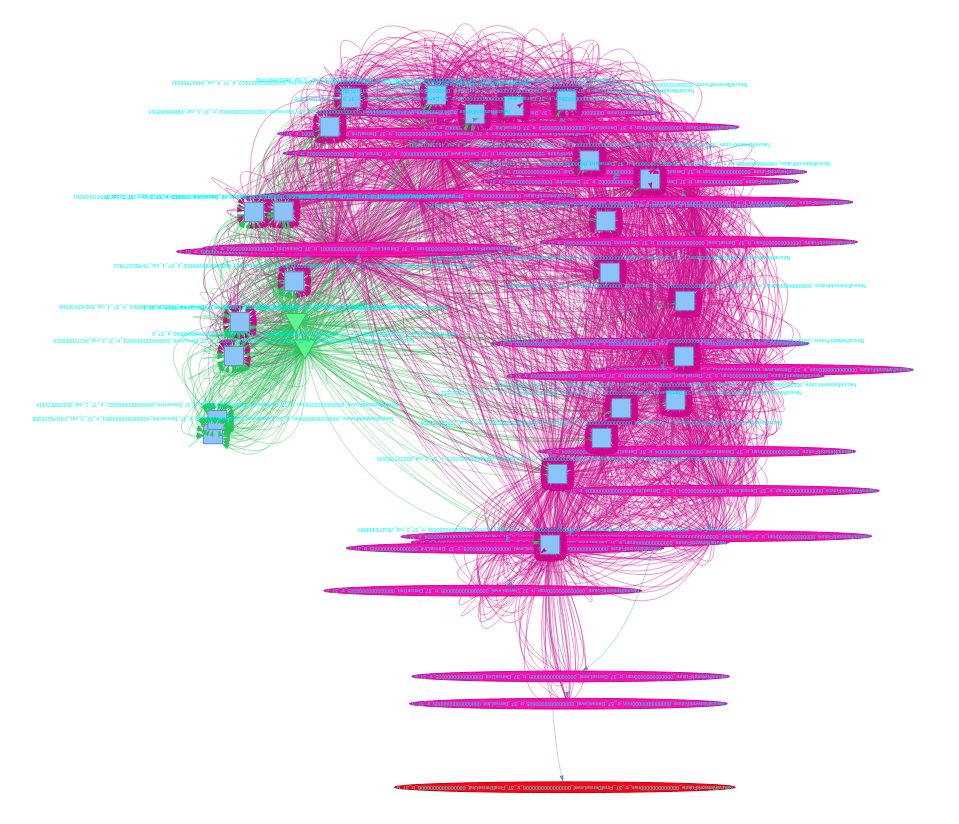


## For a more readable view of that this looks like

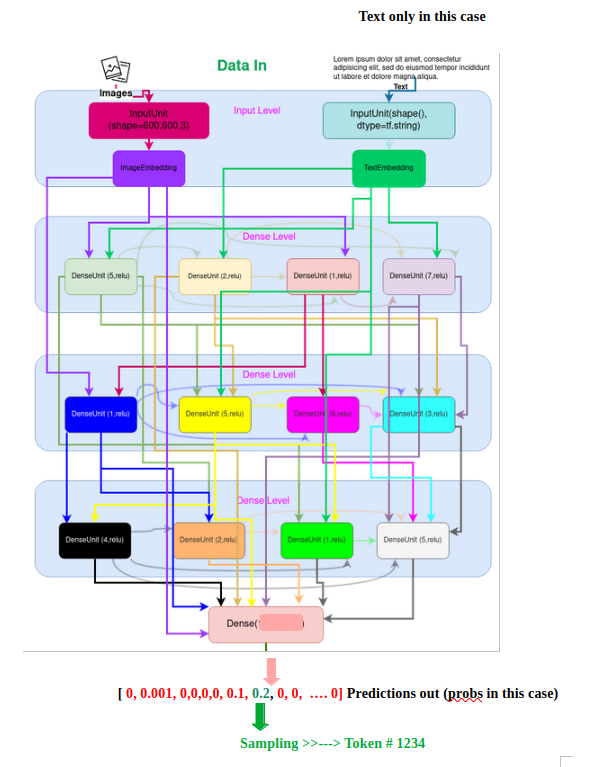


In [17]:
######## Instantiate Cerebros Neural Architecture Search #######

# Project metadata
TIME = pendulum.now(tz='America/New_York').__str__()[:16].replace('T', '_').replace(':', '_').replace('-', '_')
PROJECT_NAME = f'{TIME}_cerebros_not-gpt'
meta_trial_number = 42

# Initialize the AutoML search
cerebros_automl = SimpleCerebrosRandomSearch(
    unit_type=DenseUnit,
    input_shapes=INPUT_SHAPES,
    output_shapes=OUTPUT_SHAPES,
    training_data=x_train_packaged,
    labels=y_train_packaged,
    validation_split=0.2,
    direction='minimize',
    metric_to_rank_by="perplexity",
    minimum_levels=minimum_levels,
    maximum_levels=maximum_levels,
    minimum_units_per_level=minimum_units_per_level,
    maximum_units_per_level=maximum_units_per_level,
    minimum_neurons_per_unit=minimum_neurons_per_unit,
    maximum_neurons_per_unit=maximum_neurons_per_unit,
    activation=activation,
    final_activation='softmax',
    number_of_architecture_moities_to_try=moities_to_try,
    number_of_tries_per_architecture_moity=tries_per_moity,
    predecessor_level_connection_affinity_factor_first=predecessor_level_connection_affinity_factor_first,
    predecessor_level_connection_affinity_factor_main=predecessor_level_connection_affinity_factor_main,
    predecessor_level_connection_affinity_factor_decay_main=zero_7_exp_decay,
    max_consecutive_lateral_connections=max_consecutive_lateral_connections,
    p_lateral_connection=p_lateral_connection,
    p_lateral_connection_decay=zero_95_exp_decay,
    num_lateral_connection_tries_per_unit=num_lateral_connection_tries_per_unit,
    learning_rate=learning_rate,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), perplexity_metric],
    epochs=epochs,
    project_name=f"{PROJECT_NAME}_meta_{meta_trial_number}",
    model_graphs='model_graphs',
    batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    meta_trial_number=meta_trial_number,
    base_models=[cerebros_base_model],
    train_data_dtype=tf.int32
)

# Run the Cerebros Neural Architecture Search


In [18]:
cerebros_t0 = time.time()
phase_i_a_result_0 = cerebros_automl.run_random_search()
cerebros_t1 = time.time()

# Report results
cerebros_time_all_models_min = (cerebros_t1 - cerebros_t0) / 60
models_tried = moities_to_try * tries_per_moity
cerebros_time_per_model = cerebros_time_all_models_min / models_tried
phase_i_a_result = float(phase_i_a_result_0)

print(f"Cerebros trained {models_tried} models in {cerebros_time_all_models_min:.2f} min. Average time per model: {cerebros_time_per_model:.2f} min.")
print(f'Cerebros best perplexity achieved in Phase I-a is {phase_i_a_result}')

Global task progress:   0%|          | 0/3 [00:00<?, ?it/s]

SimpleCerebrosRandomSearch.input_shapes: [(40,)]
nan
>nnf>ceil
k is: 0 value is: [{'1': <class 'cerebros.units.units.InputUnit'>}]
0
k is: 1 value is: [{'2': <class 'cerebros.units.units.DenseUnit'>}, {'2': <class 'cerebros.units.units.DenseUnit'>}]
1
Trying to create level 1
We think level 1's predecessors are: [0]
k is: 2 value is: [{'128260': <class 'cerebros.units.units.FinalDenseUnit'>}]
2
Trying to create Final level 2
Trying to create level 2
We think level final level 2's predecessors are: [0, 1]
levels:
[0, 1, 2]
{'0': 'InputUnitModule'}
InputLevel.input_shapes [(40,)]
{'2': <class 'cerebros.units.units.DenseUnit'>}
{'2': <class 'cerebros.units.units.DenseUnit'>}
Debug: I am 2 selecting 1
debug: meta_level_number
debug: meta_level_number
debug: meta_level_number
Setting levels_unmaterialized[0] level_number 0 to have first successor: levels_unmaterialized[:1], having level_numbers of [1, 2]
Setting levels_unmaterialized[1] level_number 1 to have first successor: levels_unmater

Model: "NeuralNetworkFuture_0000000000000nan_tr_0_nn_materialized"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ NeuralNetworkFutur… │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 12)        │  1,550,652 │ NeuralNetworkFut… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NeuralNetworkFutur… │ (None, 432)       │          0 │ functional[0][0], │
│ (Concatenate)       │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NeuralNetworkFutur… │ (None, 432)       │          0 │ functional[0][0], │
│ (Concatenate)       │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0], │
│                     │                   │            │ functional[0][0]

 Total params: 52,476,644 (200.18 MB)

 Trainable params: 52,474,124 (200.17 MB)

 Non-trainable params: 2,520 (9.84 KB)

None
Epoch 1/41


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: NeuralNetworkFuture_0000000000000nan_tr_0_InputLevel_0000000000000000_tr_0_InputUnit_0000000000000000_tr_0_0_inp
Received: inputs=('Tensor(shape=(None, 40))',)
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 752ms/step - categorical_accuracy: 0.0000e+00 - loss: 11.7672 - perplexity: 128956.3438 - val_categorical_accuracy: 0.0000e+00 - val_loss: 11.7557 - val_perplexity: 127482.9922
Epoch 2/41
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 547ms/step - categorical_accuracy: 0.0000e+00 - loss: 11.6423 - perplexity: 113970.0938 - val_categorical_accuracy: 0.0000e+00 - val_loss: 11.7555 - val_perplexity: 127447.9844
Epoch 3/41
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 785ms/step - categorical_accuracy: 0.1574 - loss: 11.5549 - perplexity: 104629.7031 - val_categorical_accuracy: 0.0000e+00 - val_loss: 11.7555 - val_perplexity: 127457.9531
Epoch 4/41
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - categorical_accuracy: 0.1518 - loss: 11.2911 - perplexity: 80904.3125 - val_categorical_accuracy: 0.0000e+00 - val_loss: 11.7396 - val_perplexity: 125437.5078
Epoch 5/41
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 594ms/step - categorical_accuracy: 0.0000e+00 - loss: 11.7358 - perplexity: 125450.3906 - val_categorical_accuracy: 

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Global task progress:  33%|███▎      | 1/3 [03:54<07:49, 234.85s/it]

SimpleCerebrosRandomSearch.input_shapes: [(40,)]
nan
>nnf>ceil
k is: 0 value is: [{'1': <class 'cerebros.units.units.InputUnit'>}]
0
k is: 1 value is: [{'2': <class 'cerebros.units.units.DenseUnit'>}, {'2': <class 'cerebros.units.units.DenseUnit'>}]
1
Trying to create level 1
We think level 1's predecessors are: [0]
k is: 2 value is: [{'128260': <class 'cerebros.units.units.FinalDenseUnit'>}]
2
Trying to create Final level 2
Trying to create level 2
We think level final level 2's predecessors are: [0, 1]
levels:
[0, 1, 2]
{'0': 'InputUnitModule'}
InputLevel.input_shapes [(40,)]
{'2': <class 'cerebros.units.units.DenseUnit'>}
{'2': <class 'cerebros.units.units.DenseUnit'>}
Debug: I am 2 selecting 1
debug: meta_level_number
debug: meta_level_number
debug: meta_level_number
Setting levels_unmaterialized[0] level_number 0 to have first successor: levels_unmaterialized[:1], having level_numbers of [1, 2]
Setting levels_unmaterialized[1] level_number 1 to have first successor: levels_unmater

Model: "NeuralNetworkFuture_0000000000000nan_tr_1_nn_materialized"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ NeuralNetworkFutur… │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 12)        │  1,550,652 │ NeuralNetworkFut… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NeuralNetworkFutur… │ (None, 432)       │          0 │ functional[1][0], │
│ (Concatenate)       │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NeuralNetworkFutur… │ (None, 432)       │          0 │ functional[1][0], │
│ (Concatenate)       │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0], │
│                     │                   │            │ functional[1][0]

 Total params: 52,476,644 (200.18 MB)

 Trainable params: 52,474,124 (200.17 MB)

 Non-trainable params: 2,520 (9.84 KB)

None
Epoch 1/41


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: NeuralNetworkFuture_0000000000000nan_tr_1_InputLevel_0000000000000000_tr_1_InputUnit_0000000000000000_tr_1_0_inp
Received: inputs=('Tensor(shape=(None, 40))',)
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - categorical_accuracy: 0.0000e+00 - loss: 11.7384 - perplexity: 329529.3125 - val_categorical_accuracy: 0.1667 - val_loss: 11.7688 - val_perplexity: 129164.8281
Epoch 2/41
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 595ms/step - categorical_accuracy: 0.1913 - loss: 11.2528 - perplexity: 77375.8594 - val_categorical_accuracy: 0.1667 - val_loss: 11.7502 - val_perplexity: 126778.7031
Epoch 3/41
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 518ms/step - categorical_accuracy: 0.2191 - loss: 10.8135 - perplexity: 50491.5156 - val_categorical_accuracy: 0.1667 - val_loss: 11.7425 - val_perplexity: 125805.1797
Epoch 4/41
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - categorical_accuracy: 0.1864 - loss: 10.2940 - perplexity: 30868.9629 - val_categorical_accuracy: 0.0000e+00 - val_loss: 11.7451 - val_perplexity: 126128.5781
Epoch 5/41
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 820ms/step - categorical_accuracy: 0.1913 - loss: 9.7216 - perplexity: 16997.6719 - val_categorical_accuracy: 0.0000e+00 - val_loss: 11.7

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Global task progress:  67%|██████▋   | 2/3 [07:42<03:50, 230.58s/it]

SimpleCerebrosRandomSearch.input_shapes: [(40,)]
nan
>nnf>ceil
k is: 0 value is: [{'1': <class 'cerebros.units.units.InputUnit'>}]
0
k is: 1 value is: [{'2': <class 'cerebros.units.units.DenseUnit'>}, {'2': <class 'cerebros.units.units.DenseUnit'>}]
1
Trying to create level 1
We think level 1's predecessors are: [0]
k is: 2 value is: [{'128260': <class 'cerebros.units.units.FinalDenseUnit'>}]
2
Trying to create Final level 2
Trying to create level 2
We think level final level 2's predecessors are: [0, 1]
levels:
[0, 1, 2]
{'0': 'InputUnitModule'}
InputLevel.input_shapes [(40,)]
{'2': <class 'cerebros.units.units.DenseUnit'>}
{'2': <class 'cerebros.units.units.DenseUnit'>}
Debug: I am 2 selecting 1
debug: meta_level_number
debug: meta_level_number
debug: meta_level_number
Setting levels_unmaterialized[0] level_number 0 to have first successor: levels_unmaterialized[:1], having level_numbers of [1, 2]
Setting levels_unmaterialized[1] level_number 1 to have first successor: levels_unmater

Model: "NeuralNetworkFuture_0000000000000nan_tr_2_nn_materialized"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ NeuralNetworkFutur… │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 12)        │  1,550,652 │ NeuralNetworkFut… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NeuralNetworkFutur… │ (None, 432)       │          0 │ functional[2][0], │
│ (Concatenate)       │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NeuralNetworkFutur… │ (None, 432)       │          0 │ functional[2][0], │
│ (Concatenate)       │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0], │
│                     │                   │            │ functional[2][0]

 Total params: 52,476,644 (200.18 MB)

 Trainable params: 52,474,124 (200.17 MB)

 Non-trainable params: 2,520 (9.84 KB)

None
Epoch 1/41


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: NeuralNetworkFuture_0000000000000nan_tr_2_InputLevel_0000000000000000_tr_2_InputUnit_0000000000000000_tr_2_0_inp
Received: inputs=('Tensor(shape=(None, 40))',)
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - categorical_accuracy: 0.0000e+00 - loss: 11.7705 - perplexity: 321629.5625 - val_categorical_accuracy: 0.0000e+00 - val_loss: 11.7229 - val_perplexity: 123359.4219
Epoch 2/41
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 553ms/step - categorical_accuracy: 0.2203 - loss: 11.1997 - perplexity: 73499.6797 - val_categorical_accuracy: 0.1667 - val_loss: 11.6443 - val_perplexity: 114043.3438
Epoch 3/41
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 810ms/step - categorical_accuracy: 0.0568 - loss: 10.8859 - perplexity: 55947.3047 - val_categorical_accuracy: 0.1667 - val_loss: 11.6099 - val_perplexity: 110179.2891
Epoch 4/41
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 764ms/step - categorical_accuracy: 0.0857 - loss: 10.3024 - perplexity: 32385.9180 - val_categorical_accuracy: 0.1667 - val_loss: 11.5822 - val_perplexity: 107167.9375
Epoch 5/41
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 804ms/step - categorical_accuracy: 0.4326 - loss: 9.0836 - perplexity: 8933.4072 - val_categorical_accuracy: 0.1667 - val_loss: 11.5889 -

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Global task progress: 100%|██████████| 3/3 [12:11<00:00, 243.86s/it]

Index(['categorical_accuracy', 'loss', 'perplexity',
       'val_categorical_accuracy', 'val_loss', 'val_perplexity',
       'trial_number', 'subtrial_number', 'model_name'],
      dtype='object')
metric_to_rank_by is: 'perplexity'
Type of metric_to_rank_by is: <class 'str'>
metric_to_rank_by is: 'perplexity'
Type of metric_to_rank_by is: <class 'str'>
Best result this trial was: 7.876600742340088
Type of best result: <class 'float'>
Best model name: 2025_11_23 16_55_cerebros_not-gpt_meta_42/models/tr_0000000000000002_subtrial_0000000000000000.keras
Cerebros trained 3 models in 12.19 min. Average time per model: 4.06 min.
Cerebros best perplexity achieved in Phase I-a is 7.876600742340088


# Training Stage I-a - Model Evaluation (Subjective):

- We retrieve the best model found during the NAS phase and test its text generation capabilities from a subjective standpoint.
- Keep in mind, this is trained on 10 text samples. It is impressive that it can generate anything, especially subjects and verbs that are on-topic and agree, and is otherwise sensible, despite being grammatically gibberish.

FYI: The generative components we imported from cerebrosllmutils:

## Model config
```python

@tf.keras.utils.register_keras_serializable(package='cerebrosllmutils', name='CerebrosNotGPTConfig')
class CerebrosNotGPTConfig:
    def __init__(self, max_sequence_length=1536, padding_token=None):
        self.max_sequence_length = max_sequence_length
        self.padding_token = padding_token

    def get_config(self):
        return {
            'max_sequence_length': self.max_sequence_length,
            'padding_token': self.padding_token
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)
```

## Model class we imported from cerebrosllmutil, having:

- Greedy sampling
- Temperature scaling
- Top p sampling
- Top k sampling
- Presence penlaty
- Frequency penalty
- Repetition penalty

```python
@tf.keras.utils.register_keras_serializable(package='cerebrosllmutils', name='CerebrosNotGPT')
class CerebrosNotGPT(tf.keras.Model):
    def __init__(self, config: Any, model: Any = None, **kwargs):
        # 1. Store the nested model argument.
        self.config = config
        self.model = model
        
        # 2. Extract and remove custom kwargs (like 'model') before calling super.
        #    This is important to prevent 'unrecognized keyword argument' errors.
        #    The nested model is already extracted and stored, so it can be safely removed.
        kwargs.pop('model', None)
        
        # 3. Call the parent constructor with the cleaned kwargs.
        super().__init__(**kwargs)

        self.max_sequence_length = config.max_sequence_length
        self.padding_token = config.padding_token

    def get_config(self):
        base_config = super().get_config()
        config_dict = {
            'config': self.config.get_config(),
        }
        
        # Explicitly handle nested model serialization.
        # This is required if Keras's automatic tracking fails.
        if self.model is not None:
            # Note: This approach might still suffer from weight loss.
            # The recommended way is to let Keras handle it automatically.
            config_dict['model'] = tf.keras.utils.serialize_keras_object(self.model)

        base_config.update(config_dict)
        return base_config

    @classmethod
    def from_config(cls, config):
        # Separate the custom config.
        config_obj_dict = config.pop('config')
        config_obj = CerebrosNotGPTConfig.from_config(config_obj_dict)
        
        # Manually extract and load the nested model.
        nested_model_config = config.pop('model', None)
        if nested_model_config:
            nested_model = tf.keras.utils.deserialize_keras_object(nested_model_config)
        else:
            nested_model = None
            
        # Reconstruct the outer model by passing the restored parts.
        return cls(config=config_obj, model=nested_model, **config)

    def call(self, inputs, training=False):
        if self.model is None:
            raise ValueError("Inner model not initialized properly")
        return self.model(inputs, training=training)

    @staticmethod
    def apply_top_k_probs(probs, k):
        if k is None or k <= 0:
            return probs
        # Flatten and argsort for indices
        sorted_indices = tf.argsort(probs, direction='DESCENDING')
        keep_indices = sorted_indices[:k]
        mask = tf.zeros_like(probs, dtype=tf.bool)
        mask = tf.tensor_scatter_nd_update(mask, tf.reshape(keep_indices, (-1, 1)),
                                           tf.ones((k,), dtype=tf.bool))
        filtered_probs = tf.where(mask, probs, tf.zeros_like(probs))
        # Renormalize
        filtered_probs = filtered_probs / tf.reduce_sum(filtered_probs)
        return filtered_probs

    @staticmethod
    def apply_top_p_probs(probs, p):
        if p is None or p >= 1.0:
            return probs
        sorted_indices = tf.argsort(probs, direction='DESCENDING')
        sorted_probs = tf.gather(probs, sorted_indices)
        cumulative_probs = tf.cumsum(sorted_probs)
        mask = cumulative_probs <= p
        # Always keep at least 1 token
        mask = tf.concat([tf.constant([True]), mask[1:]], axis=0)
        keep_indices = tf.boolean_mask(sorted_indices, mask)
        filtered_probs = tf.where(
            tf.reduce_any(tf.equal(tf.range(tf.shape(probs)[0])[:, None], keep_indices), axis=1), probs,
            tf.zeros_like(probs))
        # Renormalize
        filtered_probs = filtered_probs / tf.reduce_sum(filtered_probs)
        return filtered_probs

    def generate(self,
                 token_ids,
                 do_sample=False,
                 max_new_tokens=None,
                 temperature=1.0,
                 top_k=None,
                 top_p=None,
                 frequency_penalty=None,
                 presence_penalty=None,
                 repetition_penalty=None):
        """
        Generate text autoregressively from token IDs.
        Applies filtering in sequence: penalties -> temperature -> top-k -> top-p
        """
        # Convert token_ids to list if it's not already
        if not isinstance(token_ids, list):
            token_ids = list(token_ids)

        # Determine the actual maximum number of new tokens
        if max_new_tokens is None:
            max_new_tokens = self.max_sequence_length - len(token_ids)
        else:
            max_new_tokens = min(max_new_tokens, self.max_sequence_length - len(token_ids))

        # Initialize the generated tokens list
        generated_tokens = []
        current_tokens = token_ids.copy()

        # Autoregressive generation loop
        for _ in range(max_new_tokens):
            # Pad or truncate to max_sequence_length
            if len(current_tokens) > self.max_sequence_length:
                input_tokens = current_tokens[-self.max_sequence_length:]
            else:
                padding_needed = self.max_sequence_length - len(current_tokens)
                input_tokens = current_tokens + [self.padding_token] * padding_needed

            # Convert to tensor and get model prediction
            input_tensor = tf.constant([input_tokens], dtype=tf.int32)
            probs_nested = self.model(input_tensor)
            probs = probs_nested[0]  # Already softmax probabilities (NOT logits as comment says)
            logits = tf.math.log(probs + 10 ** -20)  # Convert to logits for penalty application

            if do_sample:
                # Apply repetition/frequency/presence penalties to logits
                if frequency_penalty is not None or presence_penalty is not None:
                    # Collect token counts from current_tokens
                    token_counts = {}
                    for t in current_tokens:
                        token_counts[t] = token_counts.get(t, 0) + 1

                    # Prepare penalty tensor
                    vocab_size = tf.shape(logits)[0]
                    penalties = tf.zeros_like(logits)

                    for token_id, count in token_counts.items():
                        if token_id >= vocab_size:
                            continue
                        penalty = 0.0
                        if presence_penalty is not None:
                            penalty += presence_penalty
                        if frequency_penalty is not None:
                            penalty += frequency_penalty * count

                        penalties = tf.tensor_scatter_nd_add(
                            penalties,
                            [[token_id]],
                            [penalty]
                        )

                    # Subtract penalties from logits
                    logits = logits - penalties

                # Apply repetition penalty (standard approach)
                if repetition_penalty is not None and repetition_penalty != 1.0:
                    # Collect unique tokens that have appeared
                    unique_tokens = list(set(current_tokens))
                    vocab_size = tf.shape(logits)[0]

                    for token_id in unique_tokens:
                        if token_id < vocab_size:
                            # Divide logits of repeated tokens by penalty
                            logits = tf.tensor_scatter_nd_update(
                                logits,
                                [[token_id]],
                                [logits[token_id] / repetition_penalty]
                            )

                # Apply temperature
                if temperature != 1.0:
                    logits = logits / temperature

                # Convert to probabilities
                probs = tf.nn.softmax(logits)

                # Apply top-k filtering (if specified)
                if top_k is not None and top_k > 0:
                    k = min(top_k, tf.shape(probs)[0])
                    # Get top-k values and indices
                    top_k_values, top_k_indices = tf.nn.top_k(probs, k=k, sorted=False)
                    # Create mask for top-k positions
                    top_k_mask = tf.scatter_nd(
                        tf.expand_dims(top_k_indices, 1),
                        tf.ones_like(top_k_values, dtype=tf.bool),
                        tf.shape(probs)
                    )
                    # Zero out non-top-k probabilities
                    probs = tf.where(top_k_mask, probs, tf.zeros_like(probs))
                    # Renormalize
                    probs = probs / tf.reduce_sum(probs)
                    print(
                        f">>> After top_k: {tf.shape(probs)} shape, {tf.reduce_sum(tf.cast(probs > 1e-8, tf.int32))} non-zero probs")

                # Apply top-p filtering (if specified)
                if top_p is not None and top_p < 1.0:
                    # Sort probabilities in descending order
                    sorted_indices = tf.argsort(probs, direction='DESCENDING')
                    sorted_probs = tf.gather(probs, sorted_indices)
                    cumulative_probs = tf.cumsum(sorted_probs)
                    # Create mask for top-p
                    mask = cumulative_probs <= top_p
                    # Always keep at least one token
                    mask = tf.concat([tf.constant([True]), mask[1:]], axis=0)
                    # Get indices to keep
                    keep_indices = tf.boolean_mask(sorted_indices, mask)
                    # Create mask for original indices
                    filter_mask = tf.scatter_nd(
                        tf.expand_dims(keep_indices, 1),
                        tf.ones_like(keep_indices, dtype=tf.bool),
                        tf.shape(probs)
                    )
                    # Apply mask and renormalize
                    probs = tf.where(filter_mask, probs, tf.zeros_like(probs))
                    probs = probs / tf.reduce_sum(probs)
                    print(
                        f">>> After top_p: {tf.shape(probs)} shape, {tf.reduce_sum(tf.cast(probs > 1e-8, tf.int32))} non-zero probs")

                # Sample from the final filtered distribution
                # Get non-zero indices and their probabilities
                non_zero_mask = probs > 1e-8
                if tf.reduce_any(non_zero_mask):
                    filtered_indices = tf.where(non_zero_mask)[:, 0]  # Get indices
                    filtered_probs = tf.boolean_mask(probs, non_zero_mask)  # Get probabilities
                    # Sample
                    sampled_local_index = tf.random.categorical(tf.math.log(filtered_probs)[None, :], 1)[0, 0]
                    # Map back to vocabulary index
                    next_token_id = int(filtered_indices[sampled_local_index].numpy())
                else:
                    # Fallback if all probabilities are zero
                    warn(
                        "Token sampling had to revert to greedy sampling, because no probs had a value > 0, unexpected")
                    next_token_id = int(tf.argmax(probs, axis=-1).numpy())

            else:
                # Greedy sampling (argmax) - apply repetition penalty if needed
                if repetition_penalty is not None and repetition_penalty != 1.0:
                    unique_tokens = list(set(current_tokens))
                    vocab_size = tf.shape(logits)[0]
                    for token_id in unique_tokens:
                        if token_id < vocab_size:
                            logits = tf.tensor_scatter_nd_update(
                                logits,
                                [[token_id]],
                                [logits[token_id] / repetition_penalty]
                            )

                next_token_id = int(tf.argmax(logits, axis=-1).numpy())

            # Check for termination condition
            if next_token_id == self.padding_token:
                break

            # Add to generated tokens and update current tokens
            generated_tokens.append(int(next_token_id))
            current_tokens.append(int(next_token_id))

            # Check if we've reached max sequence length
            if len(current_tokens) >= self.max_sequence_length:
                break

        return token_ids + generated_tokens

```


## How this LLM wrapper works under the hood: A Simple Overview

- Think of a Large Language Model like the "autocomplete" on your cell phone's keyboard that suggests the next word.
- Now, imagine you continuously click the suggested next word.
- The model picks the mathematically most likely next word, and you just go with it, and pick the next, then the next ...

### Here is the step-by-step flow of how it generates text.

1. INPUT: The Prompt

The process always starts with a piece of text from you, the user.

"Write a story"

2. STEP 1: Tokenization — From Words to Numbers

A computer doesn't understand letters or words; it understands numbers. The first step is to convert the prompt into a sequence of numbers the model can process. The tokenizer is a specialized dictionary for this job.

    What comes in: A string of text ("Write a story").
    What goes out: A list of numerical IDs ([92, 21, 54, 21, 63, ...]).

To make processing consistent, the input is always padded to a fixed length (e.g., 40 tokens). Any empty slots are filled with a special <pad_token> ID that is assigned by the tokenizer.

"Write a story"  ->  tokenizer ->  [92, 21, 54, 21, 63, 1234, 1234, ... (length 40)]

For example it may look like:
```
92   = "Write"
21   = " "
54   = "a"
63   = "story"
1234 = "<pad_token>" (Repeated until there are 40 numbers)
```

3. The Model's Core: Going From Token IDs to the Predicted Next Token:

This is the "black box" part. Inside the model, 4 basic things happen:

  1. Embedding (Converts the discrete, high-dimensional sequence of tokens into a continuous distribution of a smaller dimensionality).
  2. Positional embedding: Positional embedding: Takes the output of the embedding layer and represents their relative sequential order as a continuous distribution with a clear mathematical relationship.
  3. Prediction: Prediction: A lattice of Dense layers, arranged as columns and rows, each having randomized lateral connectivity with other Dense layers on the same row, and randomized vertical connectivity with Dense layers on other rows. This takes the positional embedding's output and returns a numerical answer from its head layer. This element, produced by the Cerebros NAS, serves as a more computationally efficient alternative to the attention block used in other LLMs. The output is of shape (BATCH_SIZE, VOCABULARY_SIZE) as logits.
  4. Output activation (Scales the output to a valid range). In this case, the raw output is a tensor of shape (BATCH_SIZE, VOCABULARY_SIZE). The numbers need to be cast as probabilities, so the valid range is:
    - Each element in the list must be in the range between 0 and 1 (inclusive).
    - The entire list of numbers must add up to 1.
    - Softmax is used to accomplish this.

As mentioned before, this is a "Single Head" model, unlike most LLMs (like GPT-3/4). Each call returns **only** the next token expected in the sequence, expressed as a list of probabilities (probs) of shape (BATCH_SIZE, VOCABULARY_SIZE).


4. Predicting the Next Word From the Output of The Final Layer:

After the model returns a list of probabilities, we must **pick the next word** from this. There are VOCABULARY_SIZE words in the vocabulary, each assigned an index position on this list.

5. Sampling

- **Greedy Sampling** The naive strategy is to just pick the highest probability in this distribution (we call this greedy sampling) and assume it is the correct next token. You then decode that token ID and use it as the next word.  Then de-code that toekn id and use that as the next word. Naively assuming the highest probability is correct makes for a few problems, including:
  - The output will be identical every time you write the same prompt.
  - Common words like "the", "and", ... will be used too often and used out of place.
  - The text will seem "dry" and lack creative appeal.
- **Beam Sampling**: The better approach, is scaling then sampling from a few of the top choices. We apply scaling to the logits and recalculate the probabilities. Then, we eliminate unlikely possibilities. This leaves a smaller set of plausible tokens, from which we randomly select the next word. The methods we use are:
  - **Presence penalty:** Steeply penalizes the logit for a token that has already been used recently or as the last word in the sequence, making it very unlikely to survive sampling and be selected. **Its purpose:** Mainly prevents the same word from being used twice **in immediate succession** "This is **the the the** problem which **this this** scaling technique should fix."
  - **Frequency penalty:** Mildly penalizes the logit for a token that has been **overused** in the text, but **not necessarily** the last or recent word, making it less likely to be chosen repeatedly but still possible. **For an example:** "This technique **like** fixes **like** this from **like** happening. It's **like** really really annoying."
  - **Repetition penalty scaling**: A penalty that balances the effects of both presence and frequency penalties, attempting to fix both problems at the same time.
  - **Temperature scaling:** Temperature scaling divides logits by a number you set for 'tempterature' to control output "creativity" vs "precision". Low temperatures less than 1 make the model's top choices more likely, creating predictable text. High temperatures greater than 1, give less likely words a better chance, leading to more diverse and random text. Basically the higher you set it, the more creative and less factual the LLM's writing will be, the lower, the more precice and factual.
  - After applying all scaling, we convert the logits back to probabilities using softmax. We then proceed to sampling:
    - **Top k sampling**: Set a number 'k'. Eliminate all but the highest k numbers on this list of scaled probabilities.
    - **Top p sampling:** Set a number 'p'. Starting from the most likely token, add up the probabilities until the sum reaches or exceeds 'p'. Keep only this cumulative set of tokens.
  
Now that we have scaled and filtered the list of tokens, we randomly pick one from the remaining options.


6. ## The Generation Loop: We just do this on repeat.

The model only predicts one word at a time. To complete text, we repeat this with the result of the original prompt + the result of predicting the next. We call this an **autoregressive** loop.


    Start with a prompt ""Write, a, story"
        
        Input: [Write, a, story]
        Model predicts the token that decodes to: "about"

    Repeat 1: New Input: The appended sequence is fed back into the model.
        New Input: [Write, a, story, about]
        Model predicts: "a"

    Repeat 2:New Input:
        New Input: [Write, a, story, about, a]
        Model predicts: "fox"

This loop continues until the model generates a special "end-of-sequence" token / pad token or it reaches its maximum length limit (40 tokens in our example).



## Revisiting the analogy of the auto complete on repeat, this is what this looks like:


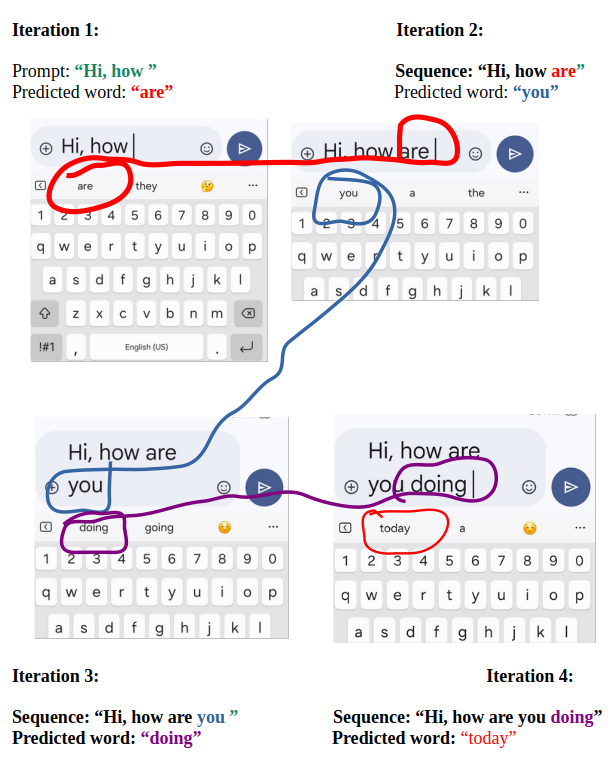

In [19]:
# Get the best model from the search
best_model_found = cerebros_automl.get_best_model(purge_model_storage_files='slate')

# Create config and generative model wrapper
config = CerebrosNotGPTConfig(
    max_sequence_length=MAX_SEQ_LENGTH,
    padding_token=tokenizer.pad_token_id
)
generator = CerebrosNotGPT(config, model=best_model_found)

# Test if the model can be built successfully
text = "This is a test ..."
input_ids = tokenizer(text, add_special_tokens=False)['input_ids']
current_tokens = input_ids.copy()
PADDING_TOKEN = tokenizer.pad_token_id

if len(current_tokens) > MAX_SEQ_LENGTH:
    input_tokens = current_tokens[-MAX_SEQ_LENGTH:]
else:
    padding_needed = MAX_SEQ_LENGTH - len(current_tokens)
    input_tokens = current_tokens + [PADDING_TOKEN] * padding_needed

# A dummy pass to force the model to build

input_tensor = tf.constant([input_tokens], dtype=tf.int32)

try:
    _ = generator(input_tensor)
    print("✅ Building LLM Model Successful!")
except Exception as exc:
    error_message = f"❌ Building model returned the error: {exc}"
    print(error_message)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'interleaved_ro_pe', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


✅ Building LLM Model Successful!


# Text Generation Utilities

We define two helper functions for text generation:

- One for greedy sampling
- One for beam sampling with various parameters.

In [20]:

# Required parameter

trial_number  =1


# Utility function for greedy sampling
def complete_text_greedy(text: str, max_new_tokens: int = 10) -> str:
    input_ids = tokenizer(text, add_special_tokens=False)['input_ids']
    generated_tokens = generator.generate(
        token_ids=input_ids,
        do_sample=False,
        max_new_tokens=max_new_tokens
    )
    generated_text = tokenizer.decode(generated_tokens).replace(text, "")
    return generated_text

# Utility function for beam sampling
def complete_text_beam(text: str,
                       max_new_tokens: int = 10,
                       temperature: float = 0.75,
                       top_k: int = 75,
                       top_p: float = 0.98,
                       repetition_penalty: float = None,
                       presence_penalty: float = 1.3,
                       frequency_penalty: float = 1.4) -> str:
    input_ids = tokenizer(text, add_special_tokens=False)['input_ids']
    generated_tokens = generator.generate(
        token_ids=input_ids,
        do_sample=True,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        presence_penalty=presence_penalty,
        frequency_penalty=frequency_penalty
    )
    generated_text = tokenizer.decode(generated_tokens).replace(text, "")
    return generated_text


# Running Generation Tests

We run a series of tests with different prompts and sampling parameters to evaluate the quality of the model from Stage I-a.

In [21]:
def test_text(test_prompt: str, max_new_tokens: int, result_cutoff: float, trial_id: int,
              test_sample_number: int, result_0: float) -> None:
    """
    If the result_0 < result_cutoff, this will run a matrix of different sampling values and print out the resulting text for human subjective evaluation.

    Parameters:
        - test_prompt: a string to prompt generation
        - max_new_tokens: int, number of tokens to generate unless we generate a stop token.
        - sample_number: Metadata for sample...
        - result_0: Perplexity score from this run
        - result_cutoff: Perplexity score that would be expected to indicate a trial worth running this pn

    """
    if result_0 < result_cutoff:
        generation_param_permutations = [
            # #3
            {
                'max_new_tokens': max_new_tokens,
                'temperature': 0.6,
                'top_k': 75,
                'top_p': 0.98,
                'repetition_penalty': None,
                'presence_penalty': 1.3,
                'frequency_penalty': 1.4
            },
            # #4
            {
                'max_new_tokens': max_new_tokens,
                'temperature': 0.7,
                'top_k': 75,
                'top_p': 0.98,
                'repetition_penalty': None,
                'presence_penalty': 1.3,
                'frequency_penalty': 1.4
            },
            # #5
            {
                'max_new_tokens': max_new_tokens,
                'temperature': 0.7,
                'top_k': 75,
                'top_p': 0.97,
                'repetition_penalty': None,
                'presence_penalty': 1.3,
                'frequency_penalty': 1.4},
            # #6
            {
                'max_new_tokens': max_new_tokens,
                'temperature': 0.75,
                'top_k': 75,
                'top_p': 0.98,
                'repetition_penalty': None,
                'presence_penalty': 1.4,
                'frequency_penalty': 1.4},
            # #7
            {
                'max_new_tokens': max_new_tokens,
                'temperature': 0.7,
                'top_k': 75,
                'top_p': 0.98,
                'repetition_penalty': None,
                'presence_penalty': 1.4,
                'frequency_penalty': 1.4},
            # #8
            {
                'max_new_tokens': max_new_tokens,
                'temperature': 0.6,
                'top_k': 75,
                'top_p': 0.98,
                'repetition_penalty': None,
                'presence_penalty': 1.4,
                'frequency_penalty': 1.4
            },
            {
                'max_new_tokens': max_new_tokens,
                'temperature': 0.6,
                'top_k': 40,
                'top_p': 0.96,
                'repetition_penalty': None,
                'presence_penalty': 1.4,
                'frequency_penalty': 1.4
            },
            {
                'max_new_tokens': max_new_tokens,
                'temperature': 0.7,
                'top_k': 45,
                'top_p': 0.97,
                'repetition_penalty': None,
                'presence_penalty': 1.4,
                'frequency_penalty': 1.3
            },  #
            {
                'max_new_tokens': max_new_tokens,
                'temperature': 0.6,
                'top_k': 75,
                'top_p': 0.99,
                'repetition_penalty': None,
                'presence_penalty': 1.4,
                'frequency_penalty': 1.4
            },
            {
                'max_new_tokens': max_new_tokens,
                'temperature': 0.65,
                'top_k': 75,
                'top_p': 0.985,
                'repetition_penalty': None,
                'presence_penalty': 1.4,
                'frequency_penalty': 1.4
            },
            {
                'max_new_tokens': max_new_tokens,
                'temperature': 0.8,
                'top_k': 75,
                'top_p': 0.99,
                'repetition_penalty': None,
                'presence_penalty': 0.7,
                'frequency_penalty': 0.7
            }
        ]
        # Default cases, no params
        response_1 = complete_text_greedy(text=test_prompt, max_new_tokens=max_new_tokens)
        print(
            f"Trial #: {trial_id} Text Sample #: {test_sample_number} Perplexity: {result_0}  GENERATE SAMPLING PARAMS: Greedy max_new_tokens=10 otherwise - N/A: PROMPT: '{test_prompt}' RESPONSE: '{response_1}'")
        # print(f"Sample {sample_number}: I ask the generator (greedy): {test_prompt}... It responds: '{response_1}'.")
        response_2 = complete_text_beam(text=test_prompt, max_new_tokens=max_new_tokens)
        print(
            f"Trial #: {trial_id} Text Sample #: {test_sample_number} Perplexity: {result_0} GENERATE PARAMS: Beam Default - max_new_tokens = 10, temperature=0.75, top_k=75,  top_p=0.98, repetition_penalty=None, presence_penalty=1.3, frequency_penalty=1.4: PROMPT: '{test_prompt}' RESPONSE: '{response_2}'.")
        # print(f"Sample {sample_number}: I ask the generator (Beam defaults - max_new_tokens: 10,  temperature: 0.75, top_k: 75, top_p: 0.98, repetition_penalty: None, presence_penalty: 1.3, frequency_penalty: 1.4): {test_prompt}... It responds: '{response_2}'.")

        for perm_0 in generation_param_permutations:
            response_0 = complete_text_beam(text=test_prompt,
                                            max_new_tokens=max_new_tokens,
                                            temperature=perm_0['temperature'],
                                            top_k=perm_0['top_k'],
                                            top_p=perm_0['top_p'],
                                            repetition_penalty=perm_0['repetition_penalty'],
                                            presence_penalty=perm_0['presence_penalty'],
                                            frequency_penalty=perm_0['frequency_penalty'])
            print(
                f"Trial #: {trial_id} Text Sample #: {test_sample_number} Perplexity: {result_0} GENERATE PARAMS: max_new_tokens={perm_0['max_new_tokens']} temperature={perm_0['temperature']}, top_k={perm_0['top_k']}, top_p={perm_0['top_p']}, repetition_penalty={perm_0['repetition_penalty']} presence_penalty={perm_0['presence_penalty']} frequency_penalty{perm_0['frequency_penalty']} PROMPT: '{test_prompt}' RESPONSE: '{response_0}'")


prompt_samples = [
        "I saw the sun and it was as shining on the",
        "And God said, Let there be light: and there ",
        "In the beginning God created the heavens"
]


counter = 0
for sample in prompt_samples:
    test_text(
            test_prompt=sample,
            max_new_tokens=MAX_NEW_TOKENS,
            result_cutoff=15,
            trial_id=trial_number,
            test_sample_number=counter,
            result_0=phase_i_a_result)
    counter += 1


collect()


Trial #: 1 Text Sample #: 0 Perplexity: 7.876600742340088  GENERATE SAMPLING PARAMS: Greedy max_new_tokens=10 otherwise - N/A: PROMPT: 'I saw the sun and it was as shining on the' RESPONSE: ' earth the the the the the the the the the the the the the the'
>>> After top_k: [128260] shape, 75 non-zero probs
>>> After top_p: [128260] shape, 6 non-zero probs
>>> After top_k: [128260] shape, 75 non-zero probs
>>> After top_p: [128260] shape, 6 non-zero probs
>>> After top_k: [128260] shape, 75 non-zero probs
>>> After top_p: [128260] shape, 7 non-zero probs
>>> After top_k: [128260] shape, 75 non-zero probs
>>> After top_p: [128260] shape, 7 non-zero probs
Trial #: 1 Text Sample #: 0 Perplexity: 7.876600742340088 GENERATE PARAMS: Beam Default - max_new_tokens = 10, temperature=0.75, top_k=75,  top_p=0.98, repetition_penalty=None, presence_penalty=1.3, frequency_penalty=1.4: PROMPT: 'I saw the sun and it was as shining on the' RESPONSE: ' earth God beginning'.
>>> After top_k: [128260] shape,

5885

# Syage I-b: Extended Training

- Now, we take the best model from Stage I-a and continue training it on a larger dataset.
- This uses a streaming `tf.data.Dataset` generator to allow handling of much larger data sets without using more RAM.
- This would allow us to select far more samples, but for now, we select a small subset for this small scale environment.

## Streaming Data Generator for Large Datasets


The **SampleExpansionGenerator** class, which we create below:

  - Applies and streams the same preprocessing logic to the raw text samples as we did in Stage I-a.
  - However, it preprocesses one **sample expansion batch** at a time and stores the resulting expanded samples in memory.
  - It then feeds the resulting expanded samples to the model in batches matching the **model's BATCH_SIZE** as requested by the training loop.
  - **sample expansion batch** is not the same as **the model's BATCH_SIZE**.

For example, we could train on a dataset of 10 \** 6 samples, while setting the **sample expansion batch size** to 100 while the **model's batch size** is 10.
  - 100 raw text samples will be expoanded at a time.
  - This results in thousands of expanded sub-samples being queued and ready for the model to take.
  - The model will take 10 of these at a time until it does not have 10 left to provide.
  - Then, the generator will then preprocess another 100 text samples and garbage collect.

This allows training on datasets that would be much larger than available memory after expansion, making the training scalable.


### The sample expansion batch size should be optimized to balance two opposing forces:

  - Memory pressure increases with the number of expanded samples held in memory.
  - Delays are caused by switching back and forth between tensor operations and preprocessing when batches are too small.



In [22]:
# Replace your existing class and function with these:
class SampleExpansionGenerator:
    def __init__(self,
                 raw_text_samples,
                 tokenizer,
                 sample_expansion_batch_size=50,
                 model_batch_size=10,
                 prompt_length_0=PROMPT_LENGTH,
                 max_seq_length=MAX_SEQ_LENGTH,
                 vocabulary_size=VOCABULARY_SIZE):

        self.raw_text_samples = raw_text_samples
        self.tokenizer = tokenizer
        self.sample_expansion_batch_size = sample_expansion_batch_size
        self.model_batch_size = model_batch_size
        self.prompt_length_0 = prompt_length_0
        self.max_seq_length = max_seq_length
        self.vocabulary_size = vocabulary_size
        self.data = []
        self.labels = []
        self.current_index = 0

    def _expand_next_batch(self):
        # If we've already processed all raw samples for this epoch, do nothing.
        if self.current_index >= len(self.raw_text_samples):
            return

        # Determine the next meta-batch
        start_idx = self.current_index
        end_idx = min(start_idx + self.sample_expansion_batch_size, len(self.raw_text_samples))

        batch_samples = self.raw_text_samples[start_idx:end_idx]
        self.current_index = end_idx

        # Run prepare_data on this batch
        input_ids_list, labels_list, _ = prepare_data(
            data_0=batch_samples,
            tokenizer_0=self.tokenizer,
            max_seq_length=self.max_seq_length,
            prompt_length=self.prompt_length_0)

        # Add the new data to our internal queues
        self.data.extend(input_ids_list)
        self.labels.extend(labels_list)

    def __iter__(self):
        # Reset to initial state for new epoch
        self.current_index = 0
        self.data = []
        self.labels = []
        return self

    def __next__(self):
        # If queues are empty, try to expand them from raw samples
        if not self.data:
            self._expand_next_batch()

        # If they are STILL empty after trying to expand, the epoch is over.
        if not self.data:
            raise StopIteration

        # Pop and return one sample
        input_sample = self.data.pop(0)
        label_sample = self.labels.pop(0)

        return ((input_sample,), label_sample)


# Create the tf.data.Dataset
def create_dataset(raw_text_samples, tokenizer, sample_expansion_batch_size=50, model_batch_size=10) -> tf.data.Dataset:
    generator_0 = SampleExpansionGenerator(
        raw_text_samples=raw_text_samples,
        tokenizer=tokenizer,
        sample_expansion_batch_size=sample_expansion_batch_size,
        model_batch_size=model_batch_size  # Pass this parameter
    )

    dataset = tf.data.Dataset.from_generator(
        lambda: generator_0,
        # output_signature=(
        #     (tf.TensorSpec(shape=(generator_0.max_seq_length,), dtype=tf.int32),),
        #     # tf.TensorSpec(shape=(generator_0.max_seq_length,), dtype=tf.int32),  # Use generator's parameter
        #     tf.TensorSpec(shape=(generator_0.vocabulary_size,), dtype=tf.float32)  # Use generator's parameter
        # )
        output_signature=(
            (tf.TensorSpec(shape=(generator_0.max_seq_length,), dtype=tf.int32),),  # A tuple containing ONE TensorSpec
            tf.TensorSpec(shape=(generator_0.vocabulary_size,), dtype=tf.float32)  # A single TensorSpec
        )
    )

    # Batch it
    dataset = dataset.batch(model_batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch for performance
    return dataset

# Create training and validation datasets
phase_i_b_train_dataset = create_dataset(
    raw_text_samples=phase_i_b_train_samples,
    tokenizer=tokenizer,
    sample_expansion_batch_size=PHASE_I_B_SAMPLE_EXPANSION_BATCH_SIZE,
    model_batch_size=batch_size
)

phase_i_b_val_dataset = create_dataset(
    raw_text_samples=phase_i_b_val_samples,
    tokenizer=tokenizer,
    sample_expansion_batch_size=PHASE_I_B_SAMPLE_EXPANSION_BATCH_SIZE,
    model_batch_size=batch_size
)


In [23]:
type(phase_i_b_train_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset


## Model Compilation for Phase I-b

- We recompile the model with the same base optimizer (AdamW), however this time with a custom learning rate scheduler (WarmupCosineDecayRestarts), and for disambiguation, relevant metrics for this training phase. We also add an EarlyStopping callback which is mainly being used to restore the weights from the best epoch, if that turns out to not be the last epoch.


## For those wanting to scale this up, a word to point out:

The parameters for the learning rate scheduler may need to be optimized. They will be different for your data. Alternatively, you can remove the learning rate scheduler if this is too much trail and error.

- We set the starting learning rate at: 0.0039295722955565125
- We set warmup steps to 1140, which for the data selected is 15 epochs.
- We set first decay steps to 1900, which for this data set is about 25 epochs.

Also:

Additionally, the early stopping callback will likely need to be adjusted. When training at scale, you may use a lower learning rate and a larger number of epochs, as well as a larger value for the start_from_epoch parameter (which specifies when to begin tracking the metric for early stopping).

FYI, this is the custom scheduler we imported from cerebrosllmutils (CosineDecayRestarts augmented with warmup steps):


```python
# A custom schedule: Cosine decay with some warm - up steps
@tf.keras.utils.register_keras_serializable(package='cerebrosllmutils', name='WarmupCosineDecayRestarts')
class WarmupCosineDecayRestarts(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    A learning rate schedule that combines a linear warmup with cosine decay restarts.
    """

    def __init__(self, initial_learning_rate, warmup_steps, first_decay_steps, t_mul=2.0, m_mul=1.0, alpha=0.0):
        super().__init__()

        # Store all parameters as public attributes for get_config serialization
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.first_decay_steps = first_decay_steps
        self.t_mul = t_mul
        self.m_mul = m_mul
        self.alpha = alpha

        # Create the CosineDecayRestarts schedule for internal logic.
        # The parameters passed here are the same ones we just stored.
        self.cosine_restarts_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=initial_learning_rate,
            first_decay_steps=first_decay_steps,
            t_mul=t_mul,
            m_mul=m_mul,
            alpha=alpha
        )


    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)

        # Calculate the learning rate for both phases unconditionally
        warmup_lr = self.initial_learning_rate * step / self.warmup_steps

        # The cosine schedule is designed to start from step 0, so we give it
        # the "post-warmup" step count.
        decay_lr = self.cosine_restarts_schedule(step - self.warmup_steps)

        # Create a multiplier that is 1.0 during warmup and 0.0 after.
        # tf.cast(condition, tf.float32) converts a boolean tensor to 1.0 or 0.0.
        warmup_multiplier = tf.cast(step < self.warmup_steps, tf.float32)

        # The decay multiplier is the opposite.
        decay_multiplier = 1.0 - warmup_multiplier

        # Combine the two learning rates. Only one will be active at a time.
        return (warmup_multiplier * warmup_lr) + (decay_multiplier * decay_lr)

    def get_config(self):
        # Use the stored public attributes for the config.
        # This bypasses the issue of accessing private attributes (_t_mul) from
        # the nested Keras object, which can be brittle.
        config = {
            "initial_learning_rate": self.initial_learning_rate,
            "warmup_steps": self.warmup_steps,
            "first_decay_steps": self.first_decay_steps,
            "t_mul": self.t_mul,
            "m_mul": self.m_mul,
            "alpha": self.alpha,
        }

        # Use from_config to properly allow deserialization
        return config
```



In [24]:
# Define loss and metrics for Phase I-b
phase_i_b_loss = tf.keras.losses.CategoricalCrossentropy()
phase_i_b_categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()
phase_i_b_perplexity = Perplexity(name="perplexity_phase_i_b")

# Create the learning rate schedule instance
lr_scheduler = WarmupCosineDecayRestarts(
    initial_learning_rate=INITIAL_LR_STAGE_I_B,
    warmup_steps=WARMUP_STEPS,
    first_decay_steps=FIRST_DECAY_STEPS_STAGE_I_B,
    t_mul=1.0,
    m_mul=0.9,
    alpha=0.01
)

# Recompile the existing model
generator.model.compile(
    loss=phase_i_b_loss,
    metrics=[phase_i_b_categorical_accuracy, phase_i_b_perplexity],
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=lr_scheduler,
        weight_decay=phase_i_b_weight_decay,
        gradient_accumulation_steps=phase_i_b_gradient_accumulation_steps
    ),
    jit_compile=True
)

# Define the Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='perplexity_phase_i_b',  # Monitor validation perplexity
    patience=10,  # Number of epochs with no improvement after which training will be stopped.
    verbose=1,
    restore_best_weights=True,  # Restores model weights from the epoch with the best value of the monitored metric.
    mode='min',
    start_from_epoch=40
)


callbacks_list = [early_stopping]


# Run Stage I-b Training

- We start the training process using the model.fit method with the new datasets and callbacks to continue training the same model on another dataset. In our at scale runs, both the previous stage and this stage are dene on far more data.

In [25]:




# print("Calculating steps per epoch...")
# train_steps = sum(1 for _ in phase_i_b_train_dataset)
# val_steps = sum(1 for _ in phase_i_b_val_dataset)
# print(f"Calculated training steps per epoch: {train_steps}")
# print(f"Calculated validation steps: {val_steps}")

# Train the model
phase_i_b_history = generator.model.fit(
    x=phase_i_b_train_dataset,
    validation_data=phase_i_b_val_dataset,
    epochs=phase_i_b_epochs,
    callbacks=callbacks_list
)

# Store history and get the best validation perplexity
phase_i_b_history = pd.DataFrame(phase_i_b_history.history)
result_phase_i_b = float(phase_i_b_history['perplexity_phase_i_b'].min())
f"Result of Stage 1-b training {result_phase_i_b}"


Epoch 1/53
     76/Unknown 69s 636ms/step - categorical_accuracy: 0.0389 - loss: 13.6508 - perplexity_phase_i_b: 966782.2500

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


76/76 ━━━━━━━━━━━━━━━━━━━━ 73s 690ms/step - categorical_accuracy: 0.0388 - loss: 13.6471 - perplexity_phase_i_b: 962529.6250 - val_categorical_accuracy: 0.0492 - val_loss: 11.5516 - val_perplexity_phase_i_b: 103939.8906
Epoch 2/53
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 609ms/step - categorical_accuracy: 0.0164 - loss: 13.8992 - perplexity_phase_i_b: 2969392.7500 - val_categorical_accuracy: 0.0492 - val_loss: 12.0771 - val_perplexity_phase_i_b: 175791.3594
Epoch 3/53
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 609ms/step - categorical_accuracy: 0.0250 - loss: 12.8039 - perplexity_phase_i_b: 402124.0625 - val_categorical_accuracy: 0.0656 - val_loss: 12.3528 - val_perplexity_phase_i_b: 231597.3438
Epoch 4/53
76/76 ━━━━━━━━━━━━━━━━━━━━ 45s 591ms/step - categorical_accuracy: 0.0415 - loss: 11.6595 - perplexity_phase_i_b: 140648.8125 - val_categorical_accuracy: 0.0492 - val_loss: 12.4123 - val_perplexity_phase_i_b: 245801.6250
Epoch 5/53
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 611ms/step - categorical_accuracy: 0.0439 - 

'Result of Stage 1-b training 29.637819290161133'

# Stage I-b: Model Evaluation and Serialization

After extended training, we evaluate the final model performance and save the model and tokenizer for future use.


# Final Generation Tests on the Stage I-b model checkpoint

Confirm the model works after Stage I-b training.

In [26]:
print("########### Phase I-b Model Checkpoint Generation Samples: ###########")

counter = 0
for sample in prompt_samples:
    test_text(
        test_prompt=sample,
        max_new_tokens=MAX_NEW_TOKENS,
        result_cutoff=60, #
        trial_id=trial_number,
        test_sample_number=counter,
        result_0=result_phase_i_b
    )
    counter += 1


########### Phase I-b Model Checkpoint Generation Samples: ###########
Trial #: 1 Text Sample #: 0 Perplexity: 29.637819290161133  GENERATE SAMPLING PARAMS: Greedy max_new_tokens=10 otherwise - N/A: PROMPT: 'I saw the sun and it was as shining on the' RESPONSE: ',,, and fruit fruit fruit fruit fruit fruit fruit fruit fruit fruit fruit'
>>> After top_k: [128260] shape, 75 non-zero probs
>>> After top_p: [128260] shape, 52 non-zero probs
>>> After top_k: [128260] shape, 75 non-zero probs
>>> After top_p: [128260] shape, 57 non-zero probs
>>> After top_k: [128260] shape, 75 non-zero probs
>>> After top_p: [128260] shape, 57 non-zero probs
>>> After top_k: [128260] shape, 75 non-zero probs
>>> After top_p: [128260] shape, 63 non-zero probs
>>> After top_k: [128260] shape, 75 non-zero probs
>>> After top_p: [128260] shape, 39 non-zero probs
>>> After top_k: [128260] shape, 75 non-zero probs
>>> After top_p: [128260] shape, 42 non-zero probs
>>> After top_k: [128260] shape, 75 non-zero probs

# Save Model and Tokenizer

- Finally, we save the tokenizer and the trained model weights to disk.

In [27]:
trial_number = 1 # Make sure to set this to a unique number:
# Serialize tokenizer
TOKENIZER_SAVE_PATH = f"tokenizer-tr-{trial_number}-stage-i-b"
tokenizer.save_pretrained(TOKENIZER_SAVE_PATH)
print(f"Tokenizer saved to {TOKENIZER_SAVE_PATH}")

# Serialize model
MODEL_SAVE_PATH = f"final_phase_ib_model_tr_{trial_number}-stage-i-b.keras"
generator.save(MODEL_SAVE_PATH)
print(f"Final model saved to {MODEL_SAVE_PATH}")


Tokenizer saved to tokenizer-tr-1-stage-i-b
Final model saved to final_phase_ib_model_tr_1-stage-i-b.keras


# Serialization Test

- We run an external script (test_llm_serialization.py) to validate that the saved model and tokenizer can be loaded and used correctly.

In [28]:
print(f"🧪 Running serialization test for Stage I-b trial {trial_number}...")
result = subprocess.run(
    f"python3 test_llm_serialization.py {TOKENIZER_SAVE_PATH} {MODEL_SAVE_PATH}",
    capture_output=True,
    shell=True,
    text=True # Use text=True for string output
)

if result.returncode == 0:
    print("✅ Serialization test passed.")
    print("STDOUT:", result.stdout)
else:
    print("❌ Serialization test failed.")
    print("STDERR:", result.stderr)
    if result.stdout:
        print("STDOUT:", result.stdout)


🧪 Running serialization test for Stage I-b trial 1...
✅ Serialization test passed.
STDOUT: ✅ Tokenizer loaded successfully.
✅ CerebrosNotGPT model loaded successfully.
>>> After top_k: [128260] shape, 50 non-zero probs
>>> After top_p: [128260] shape, 19 non-zero probs
>>> After top_k: [128260] shape, 50 non-zero probs
>>> After top_p: [128260] shape, 31 non-zero probs
>>> After top_k: [128260] shape, 50 non-zero probs
>>> After top_p: [128260] shape, 28 non-zero probs
>>> After top_k: [128260] shape, 50 non-zero probs
>>> After top_p: [128260] shape, 29 non-zero probs
>>> After top_k: [128260] shape, 50 non-zero probs
>>> After top_p: [128260] shape, 26 non-zero probs
>>> After top_k: [128260] shape, 50 non-zero probs
>>> After top_p: [128260] shape, 31 non-zero probs
>>> After top_k: [128260] shape, 50 non-zero probs
>>> After top_p: [128260] shape, 30 non-zero probs
>>> After top_k: [128260] shape, 50 non-zero probs
>>> After top_p: [128260] shape, 28 non-zero probs
>>> After top_k:

# And there you have it: What it takes to build an LLM from scratch using our novel architecture.
